---
# 데이터 로드 및 생성
---

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential

# 데이터 불러오기
train_df = pd.read_csv(r"C:\Users\BIG3-05\Downloads\open\train.csv")
test_df = pd.read_csv(r"C:\Users\BIG3-05\Downloads\open\test.csv")

# LabelEncoder를 사용하여 라벨을 숫자로 변환
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['label'])

# OneHotEncoder를 사용하여 원핫 인코딩
onehot_encoder = OneHotEncoder()
train_labels_onehot = onehot_encoder.fit_transform(train_labels_encoded.reshape(-1, 1))

# 클래스의 개수 계산
num_classes = train_labels_onehot.shape[1]

# 고해상도 이미지 로드 및 전처리 함수
def load_high_res_image(img_path, target_size=(256, 256)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0  # 이미지를 정규화
    return img

# 저해상도 이미지 로드 및 전처리 함수
def load_low_res_image(img_path, target_size=(64, 64)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0  # 이미지를 정규화
    return img

def process_images(paths_tuple, label):
    low_res_path, high_res_path = paths_tuple
    low_res_img = load_low_res_image(low_res_path)
    high_res_img = load_high_res_image(high_res_path)
    return {'input_low_res': low_res_img, 'input_high_res': high_res_img}, label

# train_labels_onehot를 희소 행렬에서 넘파이 배열로 변환
train_labels_onehot_np = train_labels_onehot.toarray()

# 변환한 넘파이 배열을 사용하여 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices(((train_df['img_path'].values, train_df['upscale_img_path'].values), train_labels_onehot_np))
train_dataset = train_dataset.shuffle(buffer_size=len(train_df))

train_dataset = train_dataset.map(process_images).batch(16)

---
# 모델 구성 및 훈련
---

In [70]:
# 모델 구성
input_high_res = layers.Input(shape=(256, 256, 3), name='input_high_res')
input_low_res = layers.Input(shape=(64, 64, 3), name='input_low_res')

def create_model():
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu')
    ])
    return model

# 고해상도 이미지 처리 모델
high_res_model = create_model()

# 저해상도 이미지 처리 모델
low_res_model = create_model()

# 두 가지 입력을 결합
merged = layers.concatenate([high_res_model, low_res_model])

output = layers.Dense(num_classes, activation='softmax')(merged)

model = models.Model(inputs=[input_high_res, input_low_res], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # 다중 클래스 분류 문제이므로 categorical_crossentropy 사용
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_dataset, epochs=10)


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 203s 204ms/step - accuracy: 0.0898 - loss: 3.1656
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 193s 195ms/step - accuracy: 0.3239 - loss: 2.3264
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 196s 198ms/step - accuracy: 0.5401 - loss: 1.5695
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 194s 196ms/step - accuracy: 0.7650 - loss: 0.8063
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 192s 194ms/step - accuracy: 0.9129 - loss: 0.3055
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 192s 194ms/step - accuracy: 0.9619 - loss: 0.1318
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 195s 197ms/step - accuracy: 0.9717 - loss: 0.1025
Epoch 8/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 194s 196ms/step - accuracy: 0.9753 - loss: 0.0887
Epoch 9/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 190s 192ms/step - accuracy: 0.9806 - loss: 0.0647
Epoch 10/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 193s 195ms/step - accuracy: 0.9779 - loss: 0.0859


---
# test 데이터 생성 및 검증
---

In [109]:
import cv2

In [ ]:
import cv2

# 모델에 고해상도 이미지와 저해상도 이미지를 입력으로 사용하여 예측
predicted_labels = []
for _, row in test_df.iterrows():
    high_res_image = row['high_res_img']
    low_res_image = cv2.imread(row['img_path'])  # 저해상도 이미지 로드
    low_res_image = cv2.resize(low_res_image, (64, 64), interpolation=cv2.INTER_CUBIC)  # 저해상도 이미지를 64x64로 크기 조정

    # 이미지를 넘파이 배열로 변환
    high_res_image = np.expand_dims(high_res_image, axis=0)
    low_res_image = np.expand_dims(low_res_image, axis=0)

    # 이미지 정규화
    high_res_image = high_res_image.astype(np.float32) / 255.0
    low_res_image = low_res_image.astype(np.float32) / 255.0

    # 모델로 예측
    predictions = model.predict([high_res_image, low_res_image])

    # 최대 값 인덱스를 사용하여 예측 레이블을 얻음
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    predicted_labels.append(predicted_label)

# 예측 결과를 테스트 데이터프레임에 추가
test_df['predicted_label'] = predicted_labels

# 테스트 결과를 파일로 저장
test_df.to_csv("test_predicted.csv", index=False)


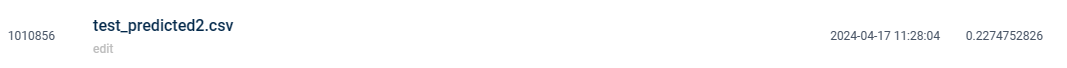